In [158]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow

In [159]:
import numpy as np
import pandas as pd

In [160]:
COMMODITY = 'magnesium'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (KG)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/KG)'
ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'
BRENT_OIL_COLUMN = 'Brent Oil Value'
WTI_OIL_COLUMN = 'WTI Oil Value'

PETROL_FILE_PATH = '../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = '../volza/magnesium/magnesium.csv'
PRICE_FILE_PATH = "../volza/magnesium/magnesium_price_2.csv"

In [161]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it.
def convert_to_kg(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185,
        'TNE': 1000,
        'KGS': 1,
        'Kgs': 1,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

## Spike detection

In [162]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = convert_to_kg(volza_pd)
volza_pd.head(3)

,ID,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (KG),Std. Unit Rate ($/KG)
0,0,2020-06-09,8104110000,MAGNESIUM METALLIC,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,5984.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,5984.0,3.025790
1,1,2020-11-25,8104110000,MAGNESIUM METALLIC INGOTS 99.95%,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,3000.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,3000.0,3.057833
3,3,2020-07-30,81041100,MAGNESIUM INGOT,PT LAUTAN LUAS TBK,NaN,POINTER INVESTEMT HK LTD,25.0,TNE,-,...,-,-,NaN,0.0,"Graha Indramas, Gedung, Jl. Ks. Tubun No.77, R...",RM 3408 CHINA MERCHANTS TOWER|SHUN TAK CENTRE ...,NaN,Indonesia T3 Import,25000.0,1.940000


In [163]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].str.replace(',', '').astype(float)
prices_pd = prices_pd[['Date','Price']]
prices_pd.head(3)

,Date,Price
0,2022-12-30,21650.0
1,2022-12-29,21650.0
2,2022-12-28,21650.0


In [164]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[[VALUE_COLUMN,QUANTITY_COLUMN,'Gross Weight']].sum()

In [165]:
# Avg of Commodity Price in Volza
avg_price_volza = volza_pd.groupby('Date')[UNIT_RATE_COLUMN].mean()
date_wise_volza = date_wise_volza.join(avg_price_volza, how='left')
date_wise_volza

,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG)
Date,,,,
2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012
2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000
2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153
2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610
2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000
...,...,...,...,...
2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999
2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118
2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332


In [166]:
# Petroleum data prep
petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


C:\Users\manim\AppData\Local\Temp\ipykernel_16876\273638861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
C:\Users\manim\AppData\Local\Temp\ipykernel_16876\273638861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


In [167]:
# Combining dataframes
prices_pd = prices_pd.set_index('Date')
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')
aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method='ffill')
aggregated_df = aggregated_df.merge(wti_df[[DATE_COLUMN, WTI_OIL_COLUMN]], on='Date', how='left').fillna(method='ffill')

C:\Users\manim\AppData\Local\Temp\ipykernel_16876\2311230880.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')
C:\Users\manim\AppData\Local\Temp\ipykernel_16876\2311230880.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method='ffill')
C:\Users\manim\AppData\Local\Temp\ipykernel_16876\2311230880.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = aggregated_df.merge(wti_df[[DATE_COLUMN, WTI_OIL_COLUMN]], on='Date', how='left').fillna(method='ffill')


In [168]:
## Detecting spikes
window_size = 20  # Adjust the window size based on your data
moving_avg = aggregated_df['Price'].rolling(window=window_size).mean()
std_dev = aggregated_df['Price'].rolling(window=window_size).std()

# Set a threshold to identify spikes
threshold = 2  # You can adjust this value based on your data
spikes = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev)
aggregated_df['spikes'] = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev).astype(int)

In [169]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,spikes
0,2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012,NaN,67.77,61.14,0
1,2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000,14150.0,67.05,61.17,0
2,2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153,14100.0,69.08,63.00,0
3,2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610,14100.0,69.08,63.00,0
4,2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000,14100.0,69.08,63.00,0
...,...,...,...,...,...,...,...,...,...
964,2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999,21700.0,82.45,79.45,0
965,2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118,21650.0,81.70,78.89,0
966,2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332,21650.0,80.96,78.43,0
967,2022-12-30,9.095473e+05,2.128420e+05,44080.0,3.949859,21650.0,82.82,80.16,0


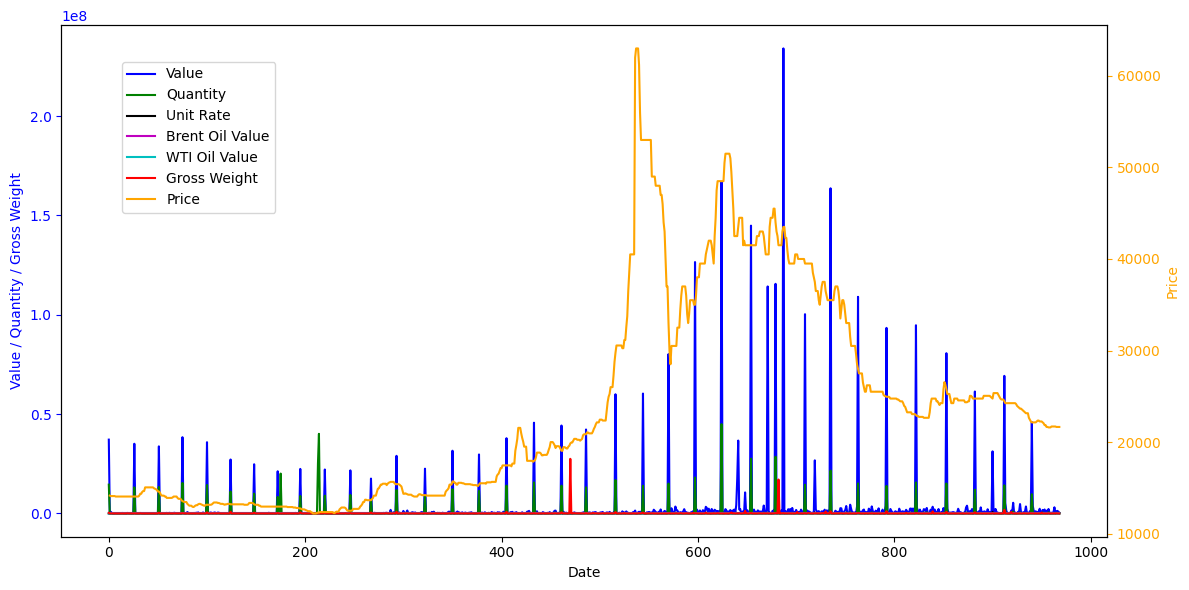

In [170]:
#Visualise Dataset

import matplotlib.pyplot as plt
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df[VALUE_COLUMN], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_COLUMN], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df[UNIT_RATE_COLUMN], label='Unit Rate', color='k')
ax1.plot(aggregated_df.index, aggregated_df[BRENT_OIL_COLUMN], label='Brent Oil Value', color='m')
ax1.plot(aggregated_df.index, aggregated_df[WTI_OIL_COLUMN], label='WTI Oil Value', color='c')
ax1.plot(aggregated_df.index, aggregated_df['Gross Weight'], label='Gross Weight', color='r')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

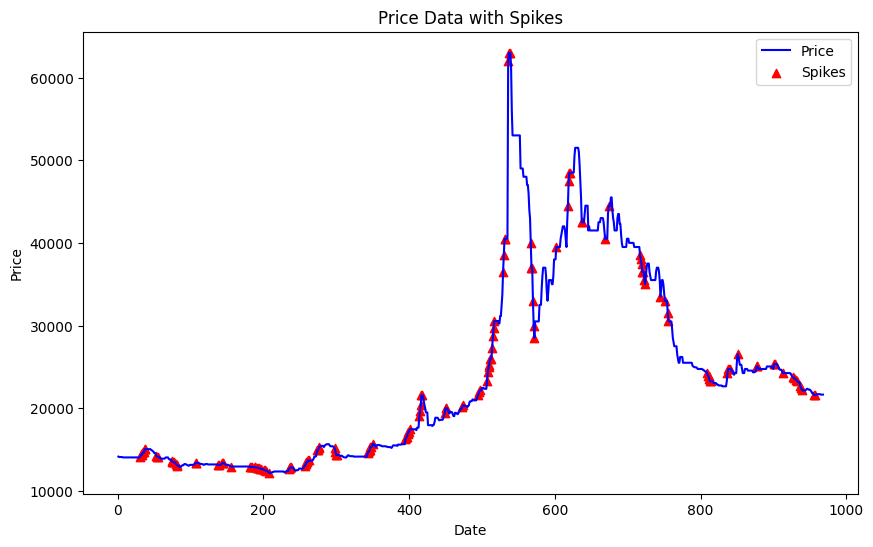

In [171]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

## Data Prep for Classification

In [172]:
FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN, WTI_OIL_COLUMN, BRENT_OIL_COLUMN]

In [173]:
# Discretize
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, columns, bins):
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    return est.fit_transform(df[columns])

test_df = aggregated_df.copy()  # Assuming aggregated_df is your DataFrame
discretized_df = discretize(test_df[FEATURE_COLUMNS], FEATURE_COLUMNS, 5)
test_df[FEATURE_COLUMNS] = discretized_df
test_df.head(2)

c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,spikes
0,2020-01-01,1.0,1.0,275000.0,0.0,NaN,2.0,3.0,0
1,2020-01-02,0.0,0.0,50080.0,0.0,14150.0,2.0,3.0,0


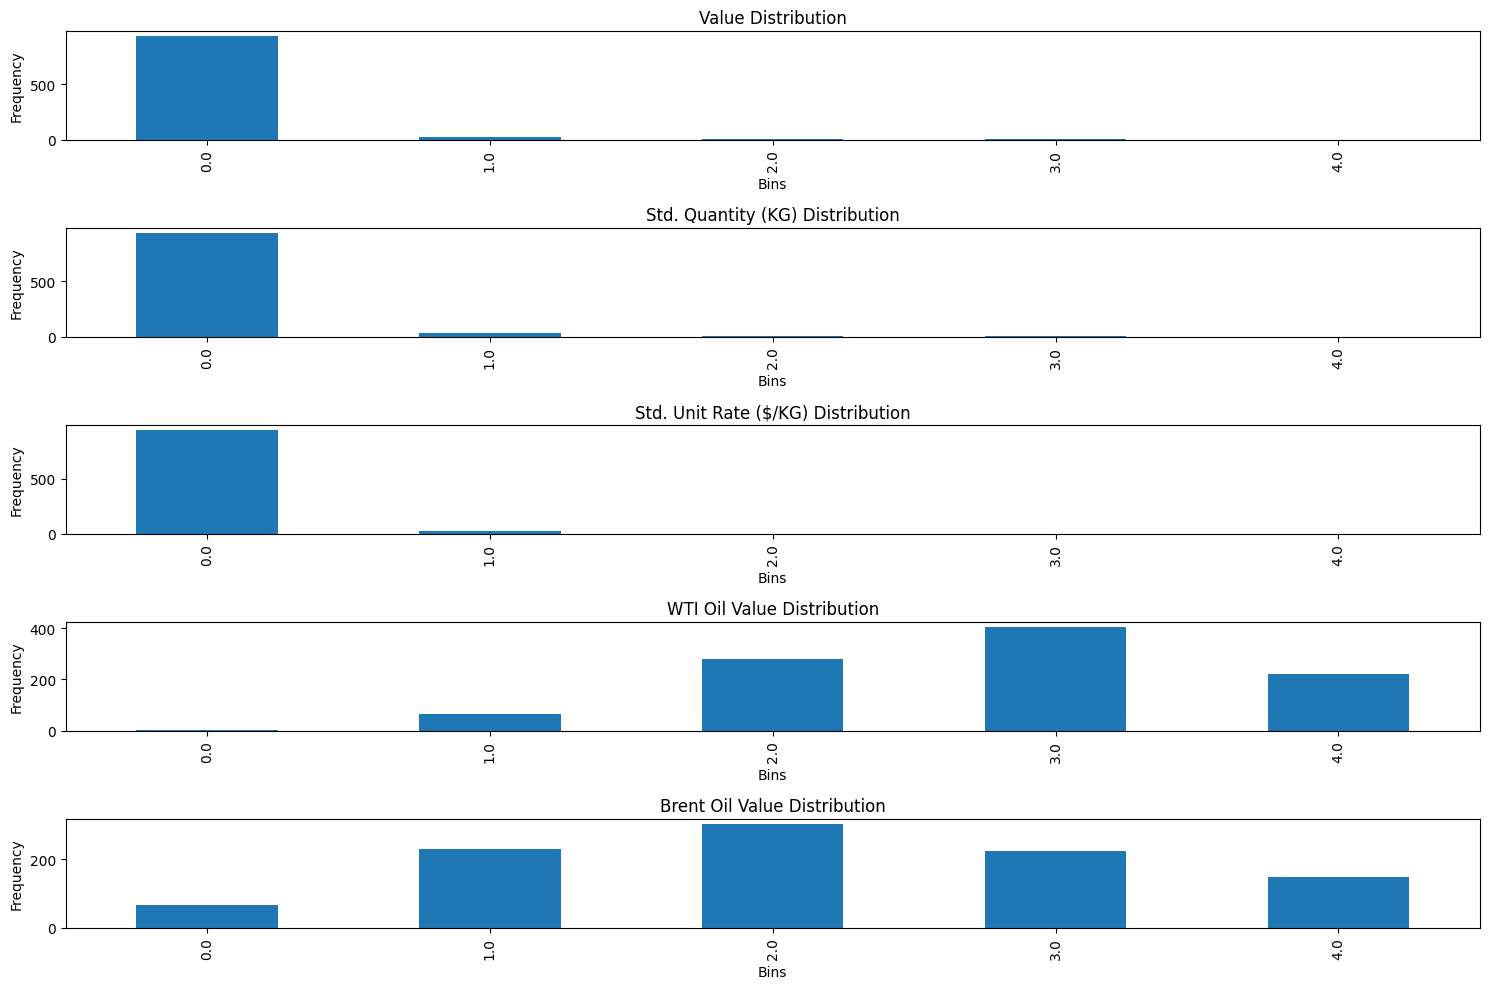

In [174]:
# Convert the discretized data into a DataFrame
discretized_df = pd.DataFrame(discretized_df, columns=FEATURE_COLUMNS)

# Count the frequencies of each bin for each feature
bin_counts = discretized_df.apply(pd.Series.value_counts).fillna(0).T

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(15, 10))

for i, column in enumerate(FEATURE_COLUMNS):
    plt.subplot(len(FEATURE_COLUMNS), 1, i + 1)

    # Plot stacked bar chart for each feature
    bin_counts.loc[column].plot(kind='bar', stacked=True, ax=plt.gca())

    plt.title(f'{column} Distribution')
    plt.ylabel('Frequency')
    plt.xlabel('Bins')

plt.tight_layout()
plt.show()


In [175]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

time_series_df = aggregated_df.copy()

# Drop rows with NaN in the 'spikes' column
time_series_df = time_series_df.dropna(subset=['spikes'])
discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, 5)
time_series_df[FEATURE_COLUMNS] = discretized_df

# Extract features and target variable
X = time_series_df[FEATURE_COLUMNS].values
y = time_series_df['spikes'].values

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for each sample with a window size of 20
window_size = 20
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - window_size + 1):
    X_sequences.append(X_scaled[i:i + window_size, :])
    y_sequences.append(y[i + window_size - 1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=50)

c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [176]:
def make_output_dict(name, params, classification_report):
    return {
        "Name": name,
        "Params": params,
        "Accuracy": classification_report["accuracy"],
        "Precision (0)": classification_report["0"]["precision"],
        "Recall (0)": classification_report["0"]["recall"],
        "F1 (0)": classification_report["0"]["f1-score"],
        "Precision (1)": classification_report["1"]["precision"],
        "Recall (1)": classification_report["1"]["recall"],
        "F1 (1)": classification_report["1"]["f1-score"],
    }

output_dicts = []

In [177]:
#LSTM Model
def evaluate_lstm(num_layers: int):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(num_layers, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


  y_pred = (model.predict(X_test) > 0.5).astype(int)


  # Generate confusion matrix
  # conf_matrix = confusion_matrix(y_test, y_pred)

  # # Calculate accuracy
  # accuracy = accuracy_score(y_test, y_pred)

  # Display confusion matrix
  # plt.figure(figsize=(6, 6))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
  #             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
  # plt.show()

  return make_output_dict(f"LSTM", f"{num_layers} layers", classification_report(y_test, y_pred, output_dict=True))


In [178]:
def evaluate_rnn(num_units: int):
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(num_units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("RNN", f"{num_units} units", classification_report(y_test, y_pred, output_dict=True))

In [179]:
def evaluate_cnn(num_filters: int, kernel_size: int):
    # Build the CNN model
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("CNN", f"{num_filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred, output_dict=True))


## LSTM (100 layers)

In [180]:
#LSTM Model

output_dicts.append(evaluate_lstm(250))
output_dicts.append(evaluate_lstm(200))
output_dicts.append(evaluate_lstm(100))
output_dicts.append(evaluate_lstm(50))

# Build the LSTM model
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# # Train the model
# print(X_train.shape)
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


# y_pred = (model.predict(X_test) > 0.5).astype(int)


# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("LSTM (100 layers)", "", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


6/6 [==============================] - 0s 2ms/step


In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


def evaluate_random_forest(n_estimators):
  # Create a Random Forest Classifier
  random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

  X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
  X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

  # Train the classifier
  random_forest.fit(X_train_reshaped, y_train)

  # Make predictions on the test set
  y_pred = random_forest.predict(X_test_reshaped)

  return make_output_dict("Random Forest", f"{n_estimators} Estimators", classification_report(y_test, y_pred, output_dict=True))

In [182]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

def create_model(input_shape, num_classes, filters, kernel_size):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters, kernel_size=kernel_size, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Reshape for attention
    reshape = Reshape((-1, 64))(pool1)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

def evaluate_attention_cnn(filters, kernel_size):
    model = create_model(X_train.shape[1:], 2, filters, kernel_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=filters, verbose=False)
    y_pred = model.predict(X_test)
    return make_output_dict("CNN with Attention", f"{filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred.argmax(axis=1), output_dict=True))

output_dicts.append(evaluate_attention_cnn(32, 5))
output_dicts.append(evaluate_attention_cnn(64, 5))
output_dicts.append(evaluate_attention_cnn(128, 5))
output_dicts.append(evaluate_attention_cnn(256, 5))
output_dicts.append(evaluate_attention_cnn(64, 3))
output_dicts.append(evaluate_attention_cnn(128, 3))
output_dicts.append(evaluate_attention_cnn(256, 3))



6/6 [==============================] - 0s 2ms/step


## Random Forrest Classifier

In [183]:
output_dicts.append(evaluate_random_forest(50))
output_dicts.append(evaluate_random_forest(25))
output_dicts.append(evaluate_random_forest(20))
output_dicts.append(evaluate_random_forest(10))
output_dicts.append(evaluate_random_forest(5))

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Create a Random Forest Classifier
# random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# # Train the classifier
# random_forest.fit(X_train_reshaped, y_train)

# # Make predictions on the test set
# y_pred = random_forest.predict(X_test_reshaped)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("Random Forest", f"", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


## RNN

In [184]:
output_dicts.append(evaluate_rnn(200))
output_dicts.append(evaluate_rnn(150))
output_dicts.append(evaluate_rnn(100))
output_dicts.append(evaluate_rnn(50))


6/6 [==============================] - 0s 1ms/step


## CNN

In [185]:
output_dicts.append(evaluate_cnn(64, 3))
output_dicts.append(evaluate_cnn(128, 3))
output_dicts.append(evaluate_cnn(256, 3))
output_dicts.append(evaluate_cnn(64, 5))
output_dicts.append(evaluate_cnn(128, 5))
output_dicts.append(evaluate_cnn(256, 5))

6/6 [==============================] - 0s 1ms/step


In [186]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

def create_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(32, kernel_size=3, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(64, kernel_size=3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # Reshape for attention
    reshape = Reshape((-1, 64))(pool2)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

create_model((X_train.shape[1], X_train.shape[2]), 2)

In [187]:
output_dicts = pd.DataFrame(output_dicts)
output_dicts.to_csv(f"{COMMODITY}_model_performance.csv")
output_dicts

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1)
0,LSTM,250 layers,0.805263,0.867470,0.905660,0.886154,0.375000,0.290323,0.327273
1,LSTM,200 layers,0.857895,0.902439,0.930818,0.916409,0.576923,0.483871,0.526316
2,LSTM,100 layers,0.873684,0.899408,0.955975,0.926829,0.666667,0.451613,0.538462
3,LSTM,50 layers,0.857895,0.888235,0.949686,0.917933,0.600000,0.387097,0.470588
4,CNN with Attention,"32 filters, kernel size 5",0.836842,0.880952,0.930818,0.905199,0.500000,0.354839,0.415094
5,CNN with Attention,"64 filters, kernel size 5",0.842105,0.890909,0.924528,0.907407,0.520000,0.419355,0.464286
6,CNN with Attention,"128 filters, kernel size 5",0.857895,0.892857,0.943396,0.917431,0.590909,0.419355,0.490566
7,CNN with Attention,"256 filters, kernel size 5",0.847368,0.877907,0.949686,0.912387,0.555556,0.322581,0.408163
8,CNN with Attention,"64 filters, kernel size 3",0.857895,0.883721,0.955975,0.918429,0.611111,0.354839,0.448980
9,CNN with Attention,"128 filters, kernel size 3",0.836842,0.867816,0.949686,0.906907,0.500000,0.258065,0.340426


## OEC Trade Data

In [188]:
# oed_data = spark.read.csv("/Users/harshdeepsingh/Downloads/trade_i_baci_a_12.tsv", header=True, sep="\t")

In [189]:
# oed_data.printSchema()
# magnesium_data = oed_data.filter(col("hs_code").like("8104%"))

In [190]:
# exported_mag_data = oed_data.groupBy("year","exporter_name").agg(F.sum("value").alias("export_value"),F.sum("quantity").alias("export_quantity"))

In [191]:
# temp = exported_mag_data.withColumn("mag_price_calc", col("export_value")/col("export_quantity")).orderBy("year")

In [192]:
# temp.filter("exporter_name == 'China'").show()